In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve



In [20]:
# Define the Newton's method function
def newtons(f, x0, TolX=1e-6, MaxIter=100, *args):
    h = 1e-4  # Step size for numerical Jacobian
    TolFun = np.finfo(float).eps  # Tolerance for function value
    x0 = np.array(x0)  # Convert x0 to a numpy array to support element-wise operations
    fx = np.array(f(x0, *args))  # Convert function output to numpy array
    Nf = len(fx)  # Number of functions
    Nx = len(x0)  # Number of variables
    
    if Nf != Nx:
        raise ValueError('Incompatible dimensions of f and x0!')
    
    xx = [x0]  # Store history of x values
    fx0 = np.linalg.norm(fx)  # Initial norm of function values
    
    for k in range(MaxIter):
        # Calculate Jacobian matrix
        J = jacob(f, xx[-1], h, *args)
        
        # Solve the system J * dx = -fx
        dx = np.linalg.solve(J, -fx)
        
        # Damping loop to avoid divergence
        for l in range(3):
            dx = dx / 2  # Apply damping
            new_x = xx[-1] + dx  # New guess
            new_fx = np.array(f(new_x, *args))  # Ensure function output is an array
            fxn = np.linalg.norm(new_fx)
            
            if fxn < fx0:  # If error reduces, accept the new solution
                xx.append(new_x)
                fx = new_fx
                break
        
        # Check for convergence
        if fxn < TolFun or np.linalg.norm(dx) < TolX:
            break
        
        fx0 = fxn  # Update fx0 for next iteration
    
    x = xx[-1]  # The final solution
    if k == MaxIter - 1:
        print(f'The best solution found after {MaxIter} iterations.')
    
    return x, fx, xx



The best solution found after 100 iterations.
Newton's Method Estimated I0: 1.00e-06 A
Newton's Method Estimated T: 300.00 K
fsolve Estimated I0: 1.72e-04 A
fsolve Estimated T: 831.60 K


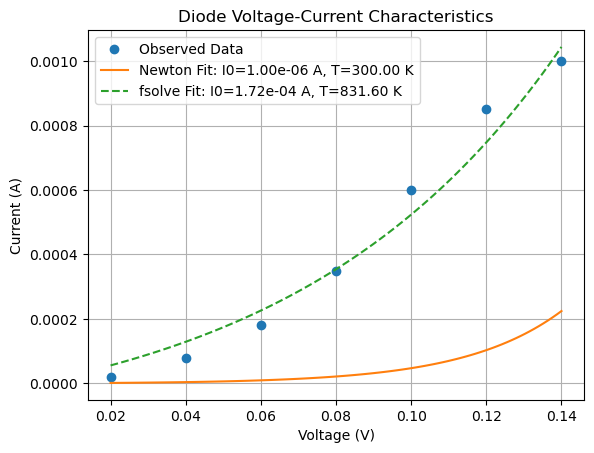

In [21]:
# Numerical Jacobian calculation function
def jacob(f, x, h=1e-4, *args):
    N = len(x)
    J = np.zeros((N, N))  # Jacobian matrix
    I = np.eye(N)  # Identity matrix
    x = np.array(x)  # Convert x to numpy array for element-wise operations
    
    for n in range(N):
        # Central difference approximation for Jacobian
        J[:, n] = (np.array(f(x + I[n] * h, *args)) - np.array(f(x - I[n] * h, *args))) / (2 * h)
    
    return J

# Diode equation system to solve
def diode_system(vars, U_data, I_data):
    I0, T = vars
    # Define the diode equation
    def diode_eq(U, I0, T):
        k = 1.38e-23  # Boltzmann constant
        e = 1.602e-19  # Electron charge
        return I0 * (np.exp(U * e / (k * T)) - 1)
    
    # Compute the current based on the model
    I_pred = diode_eq(U_data, I0, T)
    
    # Compute the residuals between the predicted and actual current values
    residuals = I_data - I_pred
    
    # Return two equations: sum of squared residuals and mean residual
    return [np.sum(residuals**2), np.mean(residuals)]

# Function to compute current using estimated I0 and T
def diode_eq(U, I0, T):
    k = 1.38e-23  # Boltzmann constant
    e = 1.602e-19  # Electron charge
    return I0 * (np.exp(U * e / (k * T)) - 1)

# Example data (replace with real data)
U_data = np.array([0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])  # Voltage (V)
I_data = np.array([0.2e-4, 0.8e-4, 1.8e-4, 3.5e-4, 6.0e-4, 8.5e-4, 10.0e-4])  # Current (A)

# Initial guess for I0 and T
initial_guess = [1e-6, 300]  # I0 in A, T in Kelvin

# Use the Newton's method to solve for I0 and T
solution_newton, final_fx, history = newtons(diode_system, initial_guess, 1e-6, 100, U_data, I_data)

I0_newton, T_newton = solution_newton

print(f"Newton's Method Estimated I0: {I0_newton:.2e} A")
print(f"Newton's Method Estimated T: {T_newton:.2f} K")

# Solve using scipy's fsolve (equivalent to MATLAB's fsolve)
def diode_system_flat(vars):
    return diode_system(vars, U_data, I_data)

solution_fsolve = fsolve(diode_system_flat, initial_guess)
I0_fsolve, T_fsolve = solution_fsolve

print(f"fsolve Estimated I0: {I0_fsolve:.2e} A")
print(f"fsolve Estimated T: {T_fsolve:.2f} K")

# Plotting the results
# Compute the predicted current values using the estimated I0 and T
U_fine = np.linspace(min(U_data), max(U_data), 100)  # Finer voltage values for smooth curve
I_predicted_newton = diode_eq(U_fine, I0_newton, T_newton)  # Predicted current values from Newton's method
I_predicted_fsolve = diode_eq(U_fine, I0_fsolve, T_fsolve)  # Predicted current values from fsolve

# Plot original data points and fitted curves
plt.plot(U_data, I_data, 'o', label='Observed Data')  # Observed data
plt.plot(U_fine, I_predicted_newton, '-', label=f'Newton Fit: I0={I0_newton:.2e} A, T={T_newton:.2f} K')  # Newton's method fitted curve
plt.plot(U_fine, I_predicted_fsolve, '--', label=f'fsolve Fit: I0={I0_fsolve:.2e} A, T={T_fsolve:.2f} K')  # fsolve fitted curve
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('Diode Voltage-Current Characteristics')
plt.legend()
plt.grid(True)
plt.show()
